# Sedimentation Test
Trying to figure out how much sedimentation contributes to SLF in NorESM

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up directories based on where the program is being run from

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
val_dir = 'sedimentatio_dev/'
os.path.exists(val_dir)

True

In [5]:
os.listdir(val_dir)

['20191219_151155_singleparam_cttest_wbf_1_inp_1.nc',
 '20200117_101940_singleparam_nudged_no_sed_1_1']

In [10]:
basecase = '20191219_151155_singleparam_cttest_wbf_1_inp_1.nc'
nosedimentation = '20200117_101940_singleparam_nudged_no_sed_1_1/atm/hist/20200117_101940_singleparam_nudged_no_sed_1_1.cam.h0.2000-01.nc'

Comparing the two runs in the Arctic shows that dentrained ice only contributes to 10-15% SLF

Text(0.5,1,'SLF trends in bulk clouds and cloud tops with detrainment changes')

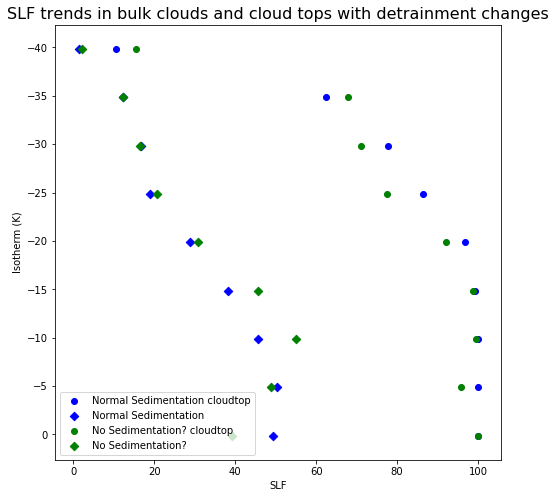

In [11]:
fig_detr = plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

cases = [basecase,nosedimentation]; names = ['Normal Sedimentation', 'No Sedimentation?']
colors = ['blue','green']
for case, name, color in zip(cases, names, colors):
    run = xr.open_dataset('%s%s' % (val_dir, case))
    run = add_weights(run)
    run['CT_SLF'] = run['CT_SLFXCLD_ISOTM']/run['CT_CLD_ISOTM']
    run['SLF'] = run['SLFXCLD_ISOTM']/run['CLD_ISOTM']
    mask = np.bitwise_or(run['lat']<66.667, run['lat']>90)
#    mask=None
    weights = run['cell_weight']
    ct_slf = 100*masked_average(run['CT_SLF'], dim=['lat','lon','time'],weights=weights, mask=mask)
    slf = 100*masked_average(run['SLF'], dim=['lat','lon','time'],weights=weights, mask=mask)

    slf_stdev = 100*np.std(run['SLF'].sel(lat=slice(66.667,90)), axis=(0,2,3))
    ct_slf_stdev = 100*np.std(run['CT_SLF'].sel(lat=slice(66.667,90)), axis=(0,2,3))

    plt.scatter(ct_slf, ct_slf['isotherms_mpc']-273, label=name+' cloudtop', color=color)
#    plt.errorbar(ct_slf, ct_slf['isotherms_mpc']-273, xerr=ct_slf_stdev, label=name+' cloudtop', color=color)
    plt.scatter(slf, slf['isotherms_mpc']-273, label=name, marker='D', color=color)
#    plt.errorbar(slf, slf['isotherms_mpc']-273, xerr=slf_stdev, label=name, marker='D', color=color)
        
plt.xlabel('SLF'); plt.ylabel('Isotherm (K)')
plt.legend(loc = 'lower left')
plt.title('SLF trends in bulk clouds and cloud tops with detrainment changes', fontsize=16)

The weird bulk cloud SLF behavior here is likely due to the fact that the dentraintest was just a 1 month run, so the January cloud behavior may not reflect the average and have large uncertainties.

In [8]:
filename = 'sedimentation_validation.png'
filename
if not os.path.exists(filename):
    fig_detr.savefig(output_dir + filename,format = 'png', dpi = 200)
    fig_detr.clf()

Define latitude ranges of interest.

In [9]:
bands = {'Global':[-90,90],'Arctic':[66.667,90],'Antarctic':[-90,-66.667]}
df = pd.DataFrame()